In [94]:
import requests
import os
import sys
import pandas as pd
import numpy as np


from typing import Optional
import glob
from scipy import stats
# Add the parent directory of this notebook to sys.path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

from project_tools import project_utils, project_class

import datetime
import json
from tqdm.notebook import tqdm
import gc
# import ds_utils
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from scipy.stats import kendalltau, spearmanr
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss, accuracy_score
from scipy import stats
%matplotlib inline

from importlib import reload
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Or for more precise control
pd.set_option('display.float_format', '{:.5f}'.format)

# evaluation functions

In [143]:
def evaluate_horse_race_positions(y_true, y_pred_proba, dnf_value=99):
    """
    Evaluate predictions for a single race's finishing positions.
    
    Args:
        y_true: 1D array of true finishing positions
        y_pred_proba: 1D array of predicted probabilities
        dnf_value: Value used to indicate Did Not Finish
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Handle NaN and DNF values in ground truth
    y_true_processed = y_true.copy()
    invalid_mask = np.logical_or(
        np.isnan(y_true),
        y_true == dnf_value
    )
    
    # Get max valid rank (excluding DNF values)
    valid_ranks = y_true[~invalid_mask]
    if len(valid_ranks) > 0:
        max_rank = np.max(valid_ranks)
        # Replace invalid values with max_rank + 1
        y_true_processed[invalid_mask] = max_rank + 1
        
    # Winner match
    y_true_ranksort = np.argsort(y_true_processed)
    y_pred_ranksort = np.argsort(y_pred_proba, axis=0)[::-1]
    
    winner_match = y_true_ranksort[0] == y_pred_ranksort[0]
    
    # Top 3 Set Match - considers [1,3,2] and [2,3,1] as matching
    top3_set_match = set(y_true_ranksort[:3]) == set(y_pred_ranksort[:3])
    
    # Top 3 Exact Match - only considers exact matches like [1,3,2] and [1,3,2]
    top3_exact_match = np.array_equal(y_true_ranksort[:3], y_pred_ranksort[:3])
    
    return {
        'Winner Match': float(winner_match),
        'Top 3 Set Match': float(top3_set_match), 
        'Top 3 Exact Match': float(top3_exact_match)
    }


In [144]:
def evaluate_prediction_sets(eval_dict):
    """
    Evaluate different prediction sets against ground truth for each race and calculate mean metrics
    
    Args:
        eval_dict: Dictionary containing race data with ground truth and different prediction sets
        
    Returns:
        tuple: (eval_result, mean_results_df)
            - eval_result: Dictionary with detailed evaluation metrics for each race
            - mean_results_df: DataFrame comparing mean metrics across prediction types
    """
    # Initialize results dictionary with race_ids as first level keys
    eval_result = {race_id: {} for race_id in eval_dict}

    # Get prediction types from first race data
    first_race_id = next(iter(eval_dict))
    pred_types = [key for key in eval_dict[first_race_id].keys() if key != 'ground_truth']

    # Initialize dictionaries to store mean results
    mean_results = {pred_type: {} for pred_type in pred_types}

    # Loop through each race
    for race_id in eval_dict:
        race_data = eval_dict[race_id]
        ground_truth = race_data['ground_truth']
        
        # Evaluate each prediction type
        for pred_type in pred_types:
            pred_probs = race_data[pred_type]
            
            # Evaluate predictions for this race
            race_eval = evaluate_horse_race_positions(
                ground_truth,
                pred_probs
            )
            
            # Store results for this race under race_id first, then pred_type
            eval_result[race_id][pred_type] = race_eval

    # Calculate mean results for each prediction type
    for pred_type in pred_types:
        # Initialize dict to store means for each metric
        metric_means = {}
        
        # Get metrics from first race to know what metrics exist
        first_race = next(iter(eval_result.values()))
        metrics = first_race[pred_type].keys()
        
        # For each metric, calculate mean across all races
        for metric in metrics:
            total = 0
            num_races = 0
            for race_id in eval_result:
                total += eval_result[race_id][pred_type][metric]
                num_races += 1
            metric_means[metric] = total / num_races
            
        mean_results[pred_type] = metric_means
    
    # Convert mean results to DataFrame for easy comparison
    mean_results_df = pd.DataFrame(mean_results)
    
    return eval_result, mean_results_df

# # Run evaluation
# eval_result, mean_results_df = evaluate_prediction_sets(eval_dict)

# # Display mean results comparison
# print("\nMean Evaluation Metrics Comparison:")
# print(mean_results_df)


# pairwise ranking functions

In [128]:
def prepare_pairwise_ranking_data(df, race_id_col='race_id', label_col='clean_position',
                                  keep_race_id_col=False):
    """
    Prepare data for pairwise ranking by generating pairs of samples within each race.
    For each race, creates pairs of horses where one finished ahead of the other.
    
    Args:
        df: DataFrame containing race data
        race_id_col: Column name for race identifier
        label_col: Column name containing finishing position
        
    Returns:
        DataFrame with pairwise samples, containing features for both horses and binary label
        indicating if first horse finished ahead of second horse
    """
    feature_cols = [c for c in df.columns if c not in [race_id_col, label_col]]
    pairs_data = []
    
    # Process each race
    for race_id in df[race_id_col].unique():
        race_df = df[df[race_id_col] == race_id].copy()
        
        # Generate all pairs of horses in this race
        for i in range(len(race_df)):
            for j in range(i+1, len(race_df)):
                horse1 = race_df.iloc[i]
                horse2 = race_df.iloc[j]
                
                # Create feature vectors for both horses
                features1 = horse1[feature_cols].values
                features2 = horse2[feature_cols].values
                
                # Label is 1 if horse1 finished ahead of horse2
                label = 1 if horse1[label_col] < horse2[label_col] else 0
                if not keep_race_id_col:                
                    pairs_data.append(np.concatenate([
                        features1,features2,[label]
                    ]))                    
                    # Add reverse pair with opposite label
                    pairs_data.append(np.concatenate([
                        features2, features1,[1-label]
                    ]))
                else:
                    pairs_data.append(np.concatenate([
                        features1,features2,[label, race_id]
                    ]))                    
                    # Add reverse pair with opposite label
                    pairs_data.append(np.concatenate([
                        features2, features1,[1-label, race_id], 
                    ]))
    
    # Create column names for paired data
    pair_cols = []
    pair_cols1 = [f'{col}_1' for col in feature_cols]
    pair_cols2 = [f'{col}_2' for col in feature_cols]
    pair_cols = pair_cols1 + pair_cols2
    pair_cols.append('label')
    if keep_race_id_col:
        pair_cols.append('race_id')    
    
    return pd.DataFrame(pairs_data, columns=pair_cols)



def train_pairwise_ranker(train_df, val_df=None, race_id_col='race_id', label_col='clean_position',
                         cat_features=None, params=None):
    """
    Train a LightGBM model for pairwise ranking of horses.
    Converts the ranking problem into binary classification of horse pairs.
    
    Args:
        train_df: Training DataFrame with features and labels
        val_df: Optional validation DataFrame
        race_id_col: Column name for race identifier 
        label_col: Column name containing position/rank labels
        cat_features: List of categorical feature names
        params: LightGBM parameters dict
        
    Returns:
        Trained model and validation predictions (if val_df provided)
    """
    # Default parameters if none provided
    if params is None:
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'max_depth': -1,
            'min_child_samples': 20,
        }
    
    # Prepare pairwise training data
    print("Preparing pairwise training data...")
    train_pairs = prepare_pairwise_ranking_data(
        train_df, 
        race_id_col=race_id_col,
        label_col=label_col
    )
    
    # Split features and labels
    X_train = train_pairs.drop('label', axis=1)
    y_train = train_pairs['label']
    
    # Handle categorical features if provided
    if cat_features:
        cat_features_pairs = []
        for feat in cat_features:
            cat_features_pairs.extend([f'{feat}_1', f'{feat}_2'])
    else:
        cat_features_pairs = 'auto'
    
    # Prepare validation data if provided
    if val_df is not None:
        print("Preparing pairwise validation data...")
        val_pairs = prepare_pairwise_ranking_data(
            val_df,
            race_id_col=race_id_col,
            label_col=label_col
        )
        X_val = val_pairs.drop('label', axis=1)
        y_val = val_pairs['label']
    
    # Initialize and train model
    print("Training model...")
    model = lgb.LGBMClassifier(**params)
    
    if val_df is not None:
        model.fit(
            X_train, y_train,
            eval_set= None, #[(X_val, y_val)],
            categorical_feature=cat_features_pairs
            # verbose=100
        )
        # Get validation metrics
        val_preds = model.predict_proba(X_val)[:, 1]
        val_logloss = log_loss(y_val, val_preds)
        val_acc = accuracy_score(y_val, val_preds > 0.5)
        print(f'Validation LogLoss: {val_logloss:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}')
        return model, val_preds
    else:
        model.fit(
            X_train, y_train,
            categorical_feature=cat_features_pairs
        )
        return model



# load data

In [40]:
horse_race_df = pd.read_parquet('../feature_data/horse_race_df.parquet')
horse_race_df = horse_race_df.sort_values(by=['clean_race_date','race_id'], ascending=True).reset_index(drop=True)
basic_cat_ordinal_df = pd.read_parquet('../feature_data/basic_cat_ordinal_features.parquet')



In [ ]:
horse_race_df 

In [16]:
target1 = 'clean_position'
df_rank = pd.read_parquet('../feature_data/baseline_features/lgbm_rank_baseline_dataset.parquet')
df_rank[target1] = horse_race_df[target1]

In [194]:
baseline_mean_results = pd.read_parquet('../evaluation_results/valdf_random_winodd_baseline_mean_results.parquet')

In [17]:
df_rank.columns

Index(['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
       'clean_win_odds', 'race_distance', 'race_id', 'jockey', 'trainer',
       'race_course', 'race_course_track', 'race_class', 'track_condition',
       'jockey_bin_0', 'jockey_bin_1', 'jockey_bin_2', 'jockey_bin_3',
       'jockey_bin_4', 'jockey_bin_5', 'jockey_bin_6', 'trainer_bin_0',
       'trainer_bin_1', 'trainer_bin_2', 'trainer_bin_3', 'trainer_bin_4',
       'trainer_bin_5', 'trainer_bin_6', 'race_course_bin_0',
       'race_course_track_bin_0', 'race_course_track_bin_1',
       'race_course_track_bin_2', 'race_course_track_bin_3',
       'race_class_bin_0', 'race_class_bin_1', 'race_class_bin_2',
       'race_class_bin_3', 'track_condition_bin_0', 'track_condition_bin_1',
       'track_condition_bin_2', 'track_condition_bin_3', 'jockey_freq',
       'trainer_freq', 'race_course_freq', 'race_course_track_freq',
       'race_class_freq', 'track_condition_freq', 'awght_dwght_ratio',
       'awght_d

# run model

In [41]:
basic_num_features = ['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
                  'clean_win_odds', 'race_distance']


basic_cat_features = basic_cat_ordinal_df.columns.tolist()

In [30]:
train_years = ['2014','2015','2016']
val_years = ['2017']
train_idx = horse_race_df[horse_race_df['year'].isin(train_years)].index
val_idx = horse_race_df[horse_race_df['year'].isin(val_years)].index
print(len(train_idx), len(val_idx))

23232 6288


In [153]:
train_df = df_rank.loc[train_idx]
train_df = train_df[train_df['clean_position']!=99].reset_index(drop=True)
val_df = df_rank.loc[val_idx]



In [39]:
# sample_train_race = train_df['race_id'].sample(100).unique()
# sample_val_race = val_df['race_id'].sample(50).unique()

# sample_train_df = train_df[train_df['race_id'].isin(sample_train_race)].reset_index(drop=True)
# sample_val_df = val_df[val_df['race_id'].isin(sample_val_race)].reset_index(drop=True)

# print(sample_train_df.shape, sample_val_df.shape)

(1261, 50) (614, 50)


In [154]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'n_estimators':300,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,  # Column sampling
    'bagging_fraction': 0.8,  # Row sampling 
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': -1,
    'min_child_samples': 20,
    'is_unbalance': True  # Handle unbalanced datasets
}

model = train_pairwise_ranker(train_df, val_df=None, cat_features=basic_cat_features, 
                              params=params)

Preparing pairwise training data...
Training model...


In [155]:
pairwise_val = prepare_pairwise_ranking_data(val_df, keep_race_id_col=True)

In [156]:
pairwise_val.shape

(72524, 98)

In [164]:
X_val = pairwise_val.drop(['label', 'race_id'], axis=1)
y_val = pairwise_val['label']
val_preds = model.predict_proba(X_val)[:,1]
pairwise_val['prediction'] = val_preds

In [165]:
val_logloss = log_loss(y_val, val_preds)
val_acc = accuracy_score(y_val, val_preds > 0.5)
print(f'Validation LogLoss: {val_logloss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

Validation LogLoss: 0.5809
Validation Accuracy: 0.6930


In [166]:
groupby_feats1 = ['race_id', 'horse_number_1']
numfeats = ['prediction']
stat = ['sum']

agg_recipies = [
    [groupby_feats1, numfeats, stat],
]

res_dfs = project_utils.groupby_agg_execution(agg_recipies, pairwise_val, verbose=False)
val_race_preds = res_dfs['race_id_horse_number_1']
val_race_preds.columns = ['race_id', 'horse_number', 'prediction']

val_df1 = val_df.copy()
on_cols = ['race_id', 'horse_number']
val_df1 = val_df.merge(right=val_race_preds, on = on_cols, how='left')

In [287]:
val_df1.to_parquet('../feature_data/model_results/val_results_lgbm_pairwise.parquet')

In [274]:
use_race_id = val_df1['race_id'].sample(1).values[0]
use_cols = ['race_id', 'horse_number', 'clean_position','prediction']
race_df = val_df1[val_df1['race_id'] == use_race_id][use_cols].sort_values(by='prediction', ascending=False)
y_true = race_df['clean_position'].values
y_pred = race_df['prediction'].values
print(evaluate_horse_race_positions(y_true, y_pred))
race_df


{'Winner Match': 1.0, 'Top 3 Set Match': 1.0, 'Top 3 Exact Match': 0.0}


,race_id,horse_number,clean_position,prediction
1699,1992,1.00000,1,10.48345
1701,1992,8.00000,3,7.81035
1700,1992,4.00000,2,7.38144
1709,1992,2.00000,11,7.17261
1705,1992,10.00000,7,7.03458
1703,1992,7.00000,5,6.32979
1710,1992,5.00000,12,6.11351
1708,1992,6.00000,10,5.64133
1707,1992,13.00000,9,5.36044
1702,1992,3.00000,4,5.30018


In [173]:
val_horse_race_df = horse_race_df.loc[val_idx].reset_index(drop=True)
pred_col = f'lgbm_pairwise_preds'
eval_dict = {}
ground_truth = {}
val_horse_race_df[pred_col] =  val_df1['prediction']


for race in val_horse_race_df['race_id'].unique():
    race_df = val_horse_race_df[val_horse_race_df['race_id']==race]
    n_horse = race_df.shape[0]    
    eval_dict[race] = {}
    eval_dict[race]['ground_truth'] = race_df['clean_position'].values
    eval_dict[race][pred_col] = race_df[pred_col].values
    
eval_result, lgbmv1_pairwise_results_df = evaluate_prediction_sets(eval_dict)
lgbmv1_pairwise_results_df

,lgbm_pairwise_preds
Winner Match,0.29746
Top 3 Set Match,0.06458
Top 3 Exact Match,0.01566


In [276]:
compare_results = baseline_mean_results.copy()
# compare_results[pred_col] = lgbmv1_iswinner_results_df[pred_col]
# compare_results[pred_col2] = lgbmv1_istop3_results_df[pred_col2]
compare_results[pred_col] = lgbmv1_pairwise_results_df
compare_results

,random_probs,winning_odd_preds,lgbm_pairwise_preds
Winner Match,0.07632,0.29354,0.29746
Top 3 Set Match,0.00783,0.05871,0.06458
Top 3 Exact Match,0.00196,0.00978,0.01566


In [278]:
impt_df = project_utils.lgbm_feature_importance(model)
print(impt_df)

                          feature  feature_importance
0                        jockey_2                1072
1                        jockey_1                1048
2                       trainer_1                 749
3                clean_win_odds_2                 702
4                       trainer_2                 696
5                clean_win_odds_1                 688
6             race_course_track_1                 482
7                 dweight_delta_1                 325
8                 dweight_delta_2                 281
9                 aweight_delta_1                 235
10            awght_dwght_ratio_1                 234
11                aweight_delta_2                 225
12            awght_dwght_ratio_2                 215
13  clean_declared_horse_weight_1                 193
14                   race_class_1                 183
15  clean_declared_horse_weight_2                 162
16            awght_dwght_delta_1                 149
17            awght_dwght_de

In [285]:
project_utils.pickle_data('../model/lgbm_pairwise_basicfeatures_deltaweight.pkl', model)

creating file ../model/lgbm_pairwise_basicfeatures_deltaweight.pkl


'../model/lgbm_pairwise_basicfeatures_deltaweight.pkl'

# results analysis

In [280]:
content_list = []
for key, value in eval_result.items():
    item_dict = {}
    item_dict['race_id'] = key
    item_dict['winner_match'] = value['lgbm_pairwise_preds']['Winner Match']
    item_dict['top3set'] = value['lgbm_pairwise_preds']['Top 3 Set Match']
    item_dict['top3exact'] = value['lgbm_pairwise_preds']['Top 3 Exact Match']
    content_list.append(item_dict)

eval_df = pd.DataFrame.from_dict(content_list)
print(eval_df.shape)
merge_cols = ['race_id', 'clean_race_date']
race_date_df = horse_race_df.drop_duplicates(merge_cols, keep='first')
eval_df = eval_df.merge(right=race_date_df[merge_cols], on='race_id', how='left')
print(eval_df.shape)

(511, 4)
(511, 5)


In [281]:
groupby_feats1 = ['clean_race_date']
numfeats = ['winner_match', 'top3set', 'top3exact']
stat = ['mean']

agg_recipies = [
    [groupby_feats1, numfeats, stat],
]

res_dfs = project_utils.groupby_agg_execution(agg_recipies, eval_df, verbose=False)
daily_eval = res_dfs['clean_race_date']
daily_eval.shape

(56, 4)

In [282]:
def convert_race_dates_and_plot_metrics3(df, date_col='race_date'):
    """
    Convert race dates from string format (YYYYMMDD) to datetime and create time series plots
    for winner match, top3 set, and top3 exact means. Only plots dates with values.
    
    Args:
        df: DataFrame containing race data with date and metric columns
        date_col: Name of column containing date strings
    """
    # Convert dates to datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], format='%Y%m%d')
    
    # Remove rows where all metric columns are null
    metrics = ['winner_match_mean', 'top3set_mean', 'top3exact_mean']
    df_clean = df.dropna(subset=metrics, how='all')
    
    # Sort by date
    df_clean = df_clean.sort_values(date_col)
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    fig.tight_layout(pad=5.0)
    
    # Plot winner match mean and rolling average
    valid_winner = df_clean.dropna(subset=['winner_match_mean'])
    ax1.plot(valid_winner[date_col], valid_winner['winner_match_mean'], 
             label='Daily Mean', color='blue')
    
    # Calculate and plot 7-day rolling average
    rolling_mean = valid_winner['winner_match_mean'].rolling(window=7, min_periods=1).mean()
    ax1.plot(valid_winner[date_col], rolling_mean, 
             label='7-day Rolling Average', color='red', linestyle='--')
    
    ax1.set_title('Winner Match Mean Over Time', pad=20)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Winner Match Mean')
    ax1.grid(True)
    ax1.legend()
    
    # Plot top3 set mean
    valid_top3set = df_clean.dropna(subset=['top3set_mean'])
    ax2.plot(valid_top3set[date_col], valid_top3set['top3set_mean'])
    ax2.set_title('Top 3 Set Mean Over Time', pad=20)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Top 3 Set Mean')
    ax2.grid(True)
    
    # Plot top3 exact mean
    valid_top3exact = df_clean.dropna(subset=['top3exact_mean'])
    ax3.plot(valid_top3exact[date_col], valid_top3exact['top3exact_mean'])
    ax3.set_title('Top 3 Exact Mean Over Time', pad=20)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Top 3 Exact Mean')
    ax3.grid(True)
    
    # Rotate x-axis labels for better readability
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='x', rotation=45)
    
    plt.show()
    
    return df_clean

In [283]:
cols = ['race_date', 'winner_match_mean', 'top3set_mean', 'top3exact_mean']
daily_eval.columns = cols

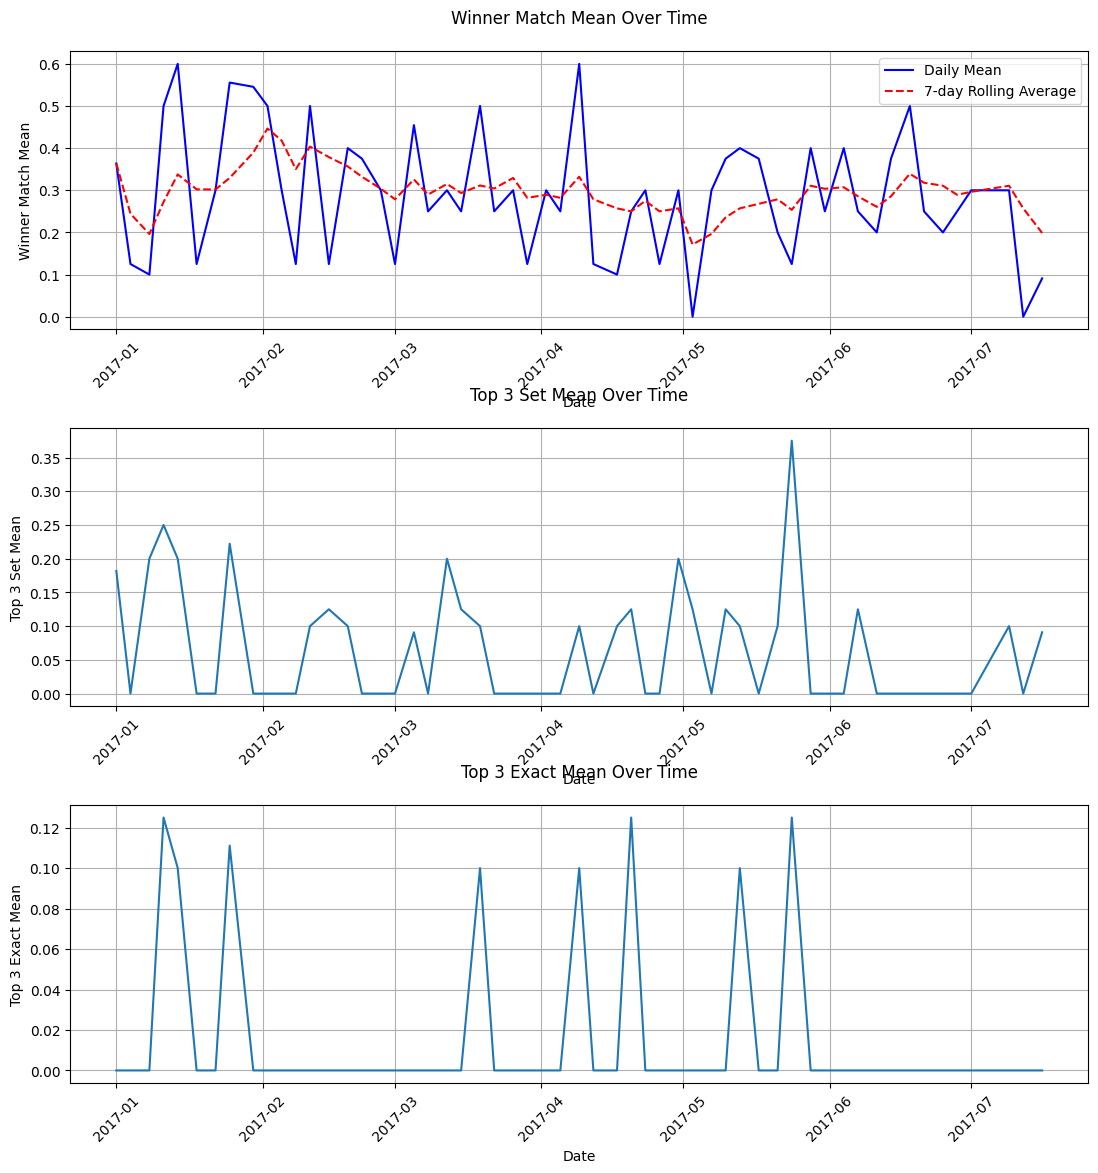

,race_date,winner_match_mean,top3set_mean,top3exact_mean
0,2017-01-01,0.36364,0.18182,0.00000
1,2017-01-04,0.12500,0.00000,0.00000
2,2017-01-08,0.10000,0.20000,0.00000
3,2017-01-11,0.50000,0.25000,0.12500
4,2017-01-14,0.60000,0.20000,0.10000
5,2017-01-18,0.12500,0.00000,0.00000
6,2017-01-22,0.30000,0.00000,0.00000
7,2017-01-25,0.55556,0.22222,0.11111
8,2017-01-30,0.54545,0.00000,0.00000
9,2017-02-02,0.50000,0.00000,0.00000


In [284]:
convert_race_dates_and_plot_metrics3(daily_eval)

In [135]:
use_cols = ['horse_number_1', 'horse_number_2', 'label', 'prediction', 'race_id']
pairwise_val[use_cols].sample(5)

,horse_number_1,horse_number_2,label,prediction,race_id
4675,2.00000,9.00000,0.00000,0.23675,2183.00000
4920,12.00000,9.00000,1.00000,0.77923,2187.00000
1822,8.00000,5.00000,1.00000,0.71186,2047.00000
2995,5.00000,8.00000,0.00000,0.05351,2126.00000
3462,2.00000,12.00000,1.00000,0.73717,2140.00000


# ad-hoc analysis

In [8]:
reload(project_utils)
check_df = horse_race_df.drop(['sectional_time'], axis=1)
project_utils.analyze_dataframe(check_df.sample(5000), verbose=False)

/home/yifan/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,feature,missing_count,missing_ratio,value_types,mean,median,min,25%,75%,max,std
0,finishing_position,0,0.00000,[str],NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,horse_number,0,0.00000,[float],6.94100,7.00000,1.00000,4.00000,10.00000,14.00000,3.74576
2,horse_name,0,0.00000,[str],NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,horse_id,0,0.00000,[str],NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,jockey,0,0.00000,[str],NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,trainer,0,0.00000,[str],NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,actual_weight,0,0.00000,[str],NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,declared_horse_weight,0,0.00000,[str],NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,draw,0,0.00000,[int],6.98240,7.00000,1.00000,4.00000,10.00000,14.00000,3.76974
9,length_behind_winner,0,0.00000,[str],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
project_utils.analyze_dataframe(df_rank, verbose=False)

/home/yifan/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,feature,missing_count,missing_ratio,value_types,mean,median,min,25%,75%,max,std
0,horse_number,0,0.00000,[float],6.88337,7.00000,1.00000,4.00000,10.00000,14.00000,3.75250
1,clean_actual_weight,0,0.00000,[float],122.91314,123.00000,103.00000,118.00000,128.00000,133.00000,6.32359
2,clean_declared_horse_weight,0,0.00000,[float],1108.99126,1107.00000,902.00000,1067.00000,1150.00000,1365.00000,60.96795
3,clean_win_odds,0,0.00000,[float],inf,16.00000,1.00000,7.69922,41.00000,99.00000,31.62500
4,race_distance,0,0.00000,[int],1415.12873,1400.00000,1000,1200.00000,1650.00000,2400,280.02927
5,race_id,0,0.00000,[int],1179.75962,1176.00000,0,590.00000,1769.00000,2366,680.61125
6,jockey,0,0.00000,[int],52.12188,48.00000,0,33.00000,69.00000,104,27.45514
7,trainer,0,0.00000,[int],38.03760,37.00000,0,10.00000,64.00000,92,30.19918
8,race_course,0,0.00000,[int],0.65955,1.00000,0,0.00000,1.00000,1,0.47387
9,race_course_track,0,0.00000,[int],5.00298,5.00000,0,2.00000,8.00000,10,3.26776


In [80]:
use_race_id = df_rank['race_id'].values[0]
df = df_rank[df_rank['race_id']==use_race_id]
df.shape

(13, 50)

In [82]:
df

,horse_number,clean_actual_weight,clean_declared_horse_weight,clean_win_odds,race_distance,race_id,jockey,trainer,race_course,race_course_track,race_class,track_condition,jockey_bin_0,jockey_bin_1,jockey_bin_2,jockey_bin_3,jockey_bin_4,jockey_bin_5,jockey_bin_6,trainer_bin_0,trainer_bin_1,trainer_bin_2,trainer_bin_3,trainer_bin_4,trainer_bin_5,trainer_bin_6,race_course_bin_0,race_course_track_bin_0,race_course_track_bin_1,race_course_track_bin_2,race_course_track_bin_3,race_class_bin_0,race_class_bin_1,race_class_bin_2,race_class_bin_3,track_condition_bin_0,track_condition_bin_1,track_condition_bin_2,track_condition_bin_3,jockey_freq,trainer_freq,race_course_freq,race_course_track_freq,race_class_freq,track_condition_freq,awght_dwght_ratio,awght_dwght_delta,dweight_delta,aweight_delta,clean_position
0,1.00000,133.00000,1032.00000,3.80078,1400,0,7,15,1,5,7,2,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,1,0,1,0,1,1,1,0,0,1,0,1353,999,19470,3367,4281,10799,0.12888,-899.00000,NaN,NaN,1
1,2.00000,133.00000,1075.00000,8.00000,1400,0,28,16,1,5,7,2,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,1,0,0,1,0,1575,1221,19470,3367,4281,10799,0.12372,-942.00000,NaN,NaN,2
2,10.00000,121.00000,1065.00000,5.69922,1400,0,102,90,1,5,7,2,1,1,0,0,1,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,1,1,0,0,1,0,698,1617,19470,3367,4281,10799,0.11362,-944.00000,NaN,NaN,3
3,3.00000,132.00000,1222.00000,6.10156,1400,0,44,11,1,5,7,2,0,1,0,1,1,0,0,0,0,0,1,0,1,1,1,0,1,0,1,0,1,1,1,0,0,1,0,1963,1425,19470,3367,4281,10799,0.10802,-1090.00000,NaN,NaN,4
4,7.00000,125.00000,1136.00000,6.10156,1400,0,104,48,1,5,7,2,1,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,1,1,0,0,1,0,1614,1100,19470,3367,4281,10799,0.11004,-1011.00000,NaN,NaN,5
5,9.00000,123.00000,1100.00000,24.00000,1400,0,3,6,1,5,7,2,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,1,1,0,0,1,0,365,1327,19470,3367,4281,10799,0.11182,-977.00000,NaN,NaN,6
6,13.00000,115.00000,1053.00000,99.00000,1400,0,20,46,1,5,7,2,0,0,1,0,1,0,0,0,1,0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,1,0,1502,1325,19470,3367,4281,10799,0.10921,-938.00000,NaN,NaN,7
7,4.00000,129.00000,1203.00000,21.00000,1400,0,40,50,1,5,7,2,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0,1,0,1130,990,19470,3367,4281,10799,0.10723,-1074.00000,NaN,NaN,8
8,6.00000,127.00000,1073.00000,10.00000,1400,0,53,83,1,5,7,2,0,1,1,0,1,0,1,1,0,1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,0,1,0,1720,1228,19470,3367,4281,10799,0.11836,-946.00000,NaN,NaN,9
9,11.00000,119.00000,1137.00000,27.00000,1400,0,90,12,1,5,7,2,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,1,1,0,0,1,0,1031,1114,19470,3367,4281,10799,0.10466,-1018.00000,NaN,NaN,10


In [90]:
print(feature_cols)

['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight', 'clean_win_odds', 'race_distance', 'jockey', 'trainer', 'race_course', 'race_course_track', 'race_class', 'track_condition', 'jockey_bin_0', 'jockey_bin_1', 'jockey_bin_2', 'jockey_bin_3', 'jockey_bin_4', 'jockey_bin_5', 'jockey_bin_6', 'trainer_bin_0', 'trainer_bin_1', 'trainer_bin_2', 'trainer_bin_3', 'trainer_bin_4', 'trainer_bin_5', 'trainer_bin_6', 'race_course_bin_0', 'race_course_track_bin_0', 'race_course_track_bin_1', 'race_course_track_bin_2', 'race_course_track_bin_3', 'race_class_bin_0', 'race_class_bin_1', 'race_class_bin_2', 'race_class_bin_3', 'track_condition_bin_0', 'track_condition_bin_1', 'track_condition_bin_2', 'track_condition_bin_3', 'jockey_freq', 'trainer_freq', 'race_course_freq', 'race_course_track_freq', 'race_class_freq', 'track_condition_freq', 'awght_dwght_ratio', 'awght_dwght_delta', 'dweight_delta', 'aweight_delta']


In [102]:
race_id_col = 'race_id'
label_col = 'clean_position'

pairs_data = []
feature_cols = [c for c in df.columns if c not in [race_id_col, label_col]]
# feature_cols
for i in range(len(df)):
    for j in range(i+1, len(df)):
        horse1 = df.iloc[i]
        horse2 = df.iloc[j]
        
        # Create feature vectors for both horses
        features1 = horse1[feature_cols].values
        features2 = horse2[feature_cols].values
        
        # Label is 1 if horse1 finished ahead of horse2
        label = 1 if horse1[label_col] < horse2[label_col] else 0
        
        pairs_data.append(np.concatenate([
            features1,
            features2,
            [label]
        ]))
        
        # Add reverse pair with opposite label
        pairs_data.append(np.concatenate([
            features2, 
            features1,
            [1-label]
        ]))
        break 
    break
pair_cols = []
# for col in feature_cols:
#     pair_cols.extend([f'{col}_1', f'{col}_2'])
pair_cols1 = [f'{col}_1' for col in feature_cols]
pair_cols2 = [f'{col}_2' for col in feature_cols]
pair_cols = pair_cols1 + pair_cols2

pair_cols.append('label')
c = pd.DataFrame(pairs_data, columns=pair_cols)
# pairs_data = []

In [99]:
pairs_data[0][1], pairs_data[1][0]

(133.0, 2.0)

In [115]:
use_cols = ['horse_number_1',  'clean_win_odds_1'] +\
            ['horse_number_2',  'clean_win_odds_2', 'label']
c[use_cols]

,horse_number_1,clean_win_odds_1,horse_number_2,clean_win_odds_2,label
0,1.00000,3.80078,2.00000,8.00000,1.00000
1,2.00000,8.00000,1.00000,3.80078,0.00000


In [27]:
res = prepare_pairwise_ranking_data(ud)

In [28]:
res.shape

(156, 97)

In [98]:
res[(res['horse_number_1']==1) | (res['horse_number_1']==2)]

,horse_number_1,horse_number_2,clean_actual_weight_1,clean_actual_weight_2,clean_declared_horse_weight_1,clean_declared_horse_weight_2,clean_win_odds_1,clean_win_odds_2,race_distance_1,race_distance_2,jockey_1,jockey_2,trainer_1,trainer_2,race_course_1,race_course_2,race_course_track_1,race_course_track_2,race_class_1,race_class_2,track_condition_1,track_condition_2,jockey_bin_0_1,jockey_bin_0_2,jockey_bin_1_1,jockey_bin_1_2,jockey_bin_2_1,jockey_bin_2_2,jockey_bin_3_1,jockey_bin_3_2,jockey_bin_4_1,jockey_bin_4_2,jockey_bin_5_1,jockey_bin_5_2,jockey_bin_6_1,jockey_bin_6_2,trainer_bin_0_1,trainer_bin_0_2,trainer_bin_1_1,trainer_bin_1_2,trainer_bin_2_1,trainer_bin_2_2,trainer_bin_3_1,trainer_bin_3_2,trainer_bin_4_1,trainer_bin_4_2,trainer_bin_5_1,trainer_bin_5_2,trainer_bin_6_1,trainer_bin_6_2,race_course_bin_0_1,race_course_bin_0_2,race_course_track_bin_0_1,race_course_track_bin_0_2,race_course_track_bin_1_1,race_course_track_bin_1_2,race_course_track_bin_2_1,race_course_track_bin_2_2,race_course_track_bin_3_1,race_course_track_bin_3_2,race_class_bin_0_1,race_class_bin_0_2,race_class_bin_1_1,race_class_bin_1_2,race_class_bin_2_1,race_class_bin_2_2,race_class_bin_3_1,race_class_bin_3_2,track_condition_bin_0_1,track_condition_bin_0_2,track_condition_bin_1_1,track_condition_bin_1_2,track_condition_bin_2_1,track_condition_bin_2_2,track_condition_bin_3_1,track_condition_bin_3_2,jockey_freq_1,jockey_freq_2,trainer_freq_1,trainer_freq_2,race_course_freq_1,race_course_freq_2,race_course_track_freq_1,race_course_track_freq_2,race_class_freq_1,race_class_freq_2,track_condition_freq_1,track_condition_freq_2,awght_dwght_ratio_1,awght_dwght_ratio_2,awght_dwght_delta_1,awght_dwght_delta_2,dweight_delta_1,dweight_delta_2,aweight_delta_1,aweight_delta_2,label
0,1.00000,133.00000,1032.00000,3.80078,1400.00000,7.00000,15.00000,1.00000,5.00000,7.00000,2.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1353.00000,999.00000,19470.00000,3367.00000,4281.00000,10799.00000,0.12888,-899.00000,NaN,NaN,2.00000,133.00000,1075.00000,8.00000,1400.00000,28.00000,16.00000,1.00000,5.00000,7.00000,2.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1575.00000,1221.00000,19470.00000,3367.00000,4281.00000,10799.00000,0.12372,-942.00000,NaN,NaN,1.00000
1,2.00000,133.00000,1075.00000,8.00000,1400.00000,28.00000,16.00000,1.00000,5.00000,7.00000,2.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1575.00000,1221.00000,19470.00000,3367.00000,4281.00000,10799.00000,0.12372,-942.00000,NaN,NaN,1.00000,133.00000,1032.00000,3.80078,1400.00000,7.00000,15.00000,1.00000,5.00000,7.00000,2.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1353.00000,999.00000,19470.00000,3367.00000,4281.00000,10799.00000,0.12888,-899.00000,NaN,NaN,0.00000
2,1.00000,133.00000,1032.00000,3.80078,1400.00000,7.00000,15.00000,1.00000,5.00000,7.00000,2.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1353.00000,999.00000,19470.00000,3367.00000,4281.00000,10799.00000,0.12888,-899.00000,NaN,NaN,10.00000,121.00000,1065.00000,5.69922,1400.00000,102.00000,90.00000,1.00000,5.00000,7.00000,2.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.